In [1]:
import pandas as pd
import numpy as np
import pybaseball as pyb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, atan2, degrees, pi
from scipy.stats import percentileofscore
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_rows', None)

In [2]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query = """
SELECT 
    pe.[PitcherId],
	pl.NamePlayer,
    pe.[PitHand],
     p.[x0]
      ,p.[y0]
      ,p.[z0]
      ,p.[vx0]
      ,p.[vy0]
      ,p.[vz0]
      ,p.[ax]
      ,p.[ay]
      ,p.[az],
    p.PitchType,
    p.StartSpeed,
    p.SpinRate,
    p.Extension,
    p.ReleaseX,
    p.ReleaseZ,
    p.ReleaseAngle,
    p.ReleaseDirection,
    p.pz,
    p.px, 
    pl.NameParentTeam
FROM 
    [mlb_stats].[dbo].[pbp_play_event] pe
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_play_event_pitch] p 
    ON p.[GamePk] = pe.[GamePk] 
    AND p.[PlayId] = pe.[PlayId] 
LEFT JOIN 
    [mlb_stats].[dbo].[pbp_game] g
    ON g.[GamePk] = pe.[GamePk]
LEFT JOIN 
    [mlb_stats].[dbo].[mlb_roster_status] pl
    ON pl.[PlayerID] = pe.[PitcherId] 
WHERE 
    pe.[IsPitch] = 1  
    AND p.PitchType = 'SI' 
    AND p.StartSpeed >= 80
    AND YEAR(g.GameDate) = 2024
    AND pl.NameParentTeam = 'Oakland Athletics'
	AND g.GameType = 'R'
"""

OAK_sinkers=pd.read_sql(query,cnxn) 

C:\Users\jreydel\AppData\Local\Temp\ipykernel_16224\138168201.py:59: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  OAK_sinkers=pd.read_sql(query,cnxn)


In [3]:
import pandas as pd #use pandas for reading in the query
import pyodbc as odbc #this package is for the database driver
from pandasql import sqldf #this is optional

#Create python connection for SQL
cnxn_str = ('Driver=SQL Server; Server=OPSDBOAK85.oaklandathletics.com; Database=mlb_stats; trusted_connection=true')

cnxn = odbc.connect(cnxn_str) #reads in the connection 


cursor = cnxn.cursor()

query_complsi = """
SELECT [Name]
      ,[PlayerID]
      ,[Throws]
      ,[Level]
      ,[LeagueLevel]
      ,[Season]
      ,[SplitType]
      ,[PitchType]
      ,[TP]
      ,[Usage]
      ,[VeloAvg]
      ,[VeloMin]
      ,[VeloMax]
      ,[wAVG]
      ,[StrikeRate]
      ,[CalledStrikeRate]
      ,[InZone]
      ,[SwingRate]
      ,[Whiff]
      ,[InZoneWhiff]
      ,[OutZoneSwing]
      ,[HorzBreak]
      ,[VertIndBreak]
      ,[VAA]
      ,[Extension]
      ,[SpinRate]
      ,[SpinAxis]
      ,[SpinEff]
      ,[Tilt]
      ,[ReleaseX]
      ,[ReleaseZ]
      ,[ZValExp]
      ,[ZValObs]
      ,[StuffGrade]
      ,[StuffGradeSwing]
      ,[StuffPlus]
      ,[CommandPlus]
      ,[GBPer]
      ,[PUPer]
      ,[HitSpeedCt]
      ,[HitSpeed]
      ,[HitAngleV]
      ,[FirstGame]
      ,[LastGame]
      ,[UpdatedDate]
  FROM [mlb_stats].[dbo].[stat_pitcher_pitch]
  WHERE Season = 2024 AND PitchType = 'SI' AND SplitType = 'All' AND CommandPlus IS NOT NULL
"""


OAK_Sinker_Command=pd.read_sql(query_complsi,cnxn) 

print(OAK_Sinker_Command)

C:\Users\jreydel\AppData\Local\Temp\ipykernel_16224\446167245.py:64: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  OAK_Sinker_Command=pd.read_sql(query_complsi,cnxn)


                          Name  PlayerID Throws Level  LeagueLevel  Season  \
0               Jansen, Kenley    445276      R   MLB            1    2024   
1                Chavez, Jesse    445926      R   MLB            1    2024   
2              Morton, Charlie    450203      R   MLB            1    2024   
3                Martin, Chris    455119      R   AAA            2    2024   
4                Martin, Chris    455119      R   MLB            1    2024   
5                Cueto, Johnny    456501      R   AAA            2    2024   
6                  Lynn, Lance    458681      R   MLB            1    2024   
7             Carrasco, Carlos    471911      R   MLB            1    2024   
8                 García, Luis    472610      R   MLB            1    2024   
9                Luetge, Lucas    476595      L   AAA            2    2024   
10                 Miley, Wade    489119      L   AAA            2    2024   
11                 Miley, Wade    489119      L   MLB           

In [4]:
def calculate_vaa(row):
    yf = 17/12  # Home plate distance in feet, converted to inches
    ay = row['ay']  # Acceleration in y-dimension for the current pitch
    vy0 = row['vy0']  # Velocity in y-dimension at y=50 feet for the current pitch
    vz0 = row['vz0']  # Velocity in z-dimension at y=50 feet for the current pitch
    az = row['az']  # Acceleration in z-dimension for the current pitch

    vy_f = -sqrt(vy0**2 - (2 * ay * (50 - yf)))
    t = (vy_f - vy0) / ay
    vz_f = vz0 + (az * t)
    vaa_rad = atan2(vz_f, vy_f)
    vaa_deg = (180+degrees(vaa_rad))*-1

    return vaa_deg
OAK_sinkers['VAA'] = OAK_sinkers.apply(calculate_vaa, axis=1)

In [5]:
def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA

In [6]:
OAK_sinkers['VRA'] = OAK_sinkers.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['Extension'], x['vz0'], x['az']), axis=1)
OAK_sinkers['HRA'] = OAK_sinkers.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['Extension'], x['vx0'], x['ax']), axis=1)

In [7]:
pitch_count = OAK_sinkers['NamePlayer'].value_counts()

OAK_si_filtered = OAK_sinkers[OAK_sinkers['NamePlayer'].isin(pitch_count.index[pitch_count >= 150])]

In [8]:
grouped_si = OAK_si_filtered.groupby(['NamePlayer', 'PitcherId']).agg({
    'VRA': 'std',
    'HRA': 'std',
    'ReleaseX': 'std',
    'ReleaseZ': 'std',
}).reset_index()  

#grouped_ff.rename(columns={'type': 'strike_rate'}, inplace=True)
weights = {'VRA_degrees': 0.42, 'HRA_degrees': 0.27, 'ReleaseZ': 0.17, 'ReleaseX': 0.14}

grouped_si['VRA_percentile'] = 1 - grouped_si['VRA'].rank(pct=True)
grouped_si['HRA_percentile'] = 1 - grouped_si['HRA'].rank(pct=True)
grouped_si['release_pos_z_percentile'] = 1 - grouped_si['ReleaseZ'].rank(pct=True)
grouped_si['release_pos_x_percentile'] = 1 - grouped_si['ReleaseX'].rank(pct=True)

grouped_si['kirby_index'] = (
    grouped_si['VRA_percentile'] * weights['VRA_degrees'] +
    grouped_si['HRA_percentile'] * weights['HRA_degrees'] +
    grouped_si['release_pos_z_percentile'] * weights['ReleaseZ'] +
    grouped_si['release_pos_x_percentile'] * weights['ReleaseX']
)

OAK_ranked_pitchers_weighted_si = grouped_si.sort_values('kirby_index', ascending=False)

In [9]:
print(OAK_ranked_pitchers_weighted_si)

           NamePlayer  PitcherId       VRA       HRA  ReleaseX  ReleaseZ  \
23     Ross Stripling     548389  0.774083  0.635510  0.120277  0.078692   
12           JP Sears     676664  0.693997  0.730344  0.088608  0.121795   
25    Scott Alexander     518397  0.753200  0.741258  0.162305  0.087729   
6      Brandon Bielak     656232  0.802785  0.648799  0.107092  0.094807   
27     T.J. McFarland     519008  0.516173  0.897361  0.118277  0.080739   
0        Aaron Brooks     605156  0.799980  0.741435  0.154451  0.098260   
18      Luis Carrasco     682918  0.746237  0.819247  0.180261  0.135258   
15       Jake Garland     687195  0.914188  0.769262  0.153690  0.113975   
2           Alex Wood     622072  0.843985  0.807570  0.113922  0.173859   
20       Mitch Spence     687765  0.971897  0.711658  0.130640  0.089532   
22     Paul Blackburn     621112  0.864654  0.872646  0.171313  0.087010   
5        Blaze Pontes     806281  0.780308  0.824130  0.190333  0.146678   
28     Tyler

In [10]:
filtered_sinker_command = OAK_Sinker_Command.loc[:, ['PlayerID', 'StrikeRate', 'CalledStrikeRate', 'CommandPlus', 'InZone']]
OAK_full_sinker_command = pd.merge(OAK_ranked_pitchers_weighted_si, filtered_sinker_command, how='left', left_on='PitcherId', right_on='PlayerID')
OAK_full_sinker_command_unique = OAK_full_sinker_command.drop_duplicates(subset=['NamePlayer'])

from IPython.display import display

display(OAK_full_sinker_command_unique)

,NamePlayer,PitcherId,VRA,HRA,ReleaseX,ReleaseZ,VRA_percentile,HRA_percentile,release_pos_z_percentile,release_pos_x_percentile,kirby_index,PlayerID,StrikeRate,CalledStrikeRate,CommandPlus,InZone
0,Ross Stripling,548389,0.774083,0.635510,0.120277,0.078692,0.806452,0.967742,0.935484,0.838710,0.876452,548389,0.746575,0.226027,65,0.554795
1,JP Sears,676664,0.693997,0.730344,0.088608,0.121795,0.935484,0.870968,0.387097,0.967742,0.829355,676664,0.676617,0.233831,55,0.557214
2,Scott Alexander,518397,0.753200,0.741258,0.162305,0.087729,0.870968,0.838710,0.838710,0.645161,0.825161,518397,0.916667,0.250000,70,0.416667
5,Brandon Bielak,656232,0.802785,0.648799,0.107092,0.094807,0.709677,0.935484,0.709677,0.935484,0.802258,656232,0.721739,0.147826,50,0.478261
7,T.J. McFarland,519008,0.516173,0.897361,0.118277,0.080739,0.967742,0.354839,0.903226,0.870968,0.777742,519008,0.748092,0.225191,60,0.603053
8,Aaron Brooks,605156,0.799980,0.741435,0.154451,0.098260,0.741935,0.806452,0.612903,0.709677,0.732903,605156,0.700297,0.157270,60,0.480712
10,Luis Carrasco,682918,0.746237,0.819247,0.180261,0.135258,0.903226,0.645161,0.193548,0.548387,0.663226,682918,0.726872,0.140969,55,0.555066
11,Jake Garland,687195,0.914188,0.769262,0.153690,0.113975,0.548387,0.774194,0.483871,0.741935,0.625484,687195,0.674479,0.197917,60,0.528646
12,Alex Wood,622072,0.843985,0.807570,0.113922,0.173859,0.645161,0.677419,0.129032,0.903226,0.602258,622072,0.666667,0.192529,45,0.540230
13,Mitch Spence,687765,0.971897,0.711658,0.130640,0.089532,0.258065,0.903226,0.774194,0.806452,0.596774,687765,0.560510,0.082803,50,0.439490


In [11]:
OAK_select = OAK_full_sinker_command_unique.loc[:, ['NamePlayer', 'StrikeRate', 'InZone', 'CommandPlus', 'kirby_index']]
display(OAK_select)

,NamePlayer,StrikeRate,InZone,CommandPlus,kirby_index
0,Ross Stripling,0.746575,0.554795,65,0.876452
1,JP Sears,0.676617,0.557214,55,0.829355
2,Scott Alexander,0.916667,0.416667,70,0.825161
5,Brandon Bielak,0.721739,0.478261,50,0.802258
7,T.J. McFarland,0.748092,0.603053,60,0.777742
8,Aaron Brooks,0.700297,0.480712,60,0.732903
10,Luis Carrasco,0.726872,0.555066,55,0.663226
11,Jake Garland,0.674479,0.528646,60,0.625484
12,Alex Wood,0.666667,0.540230,45,0.602258
13,Mitch Spence,0.560510,0.439490,50,0.596774


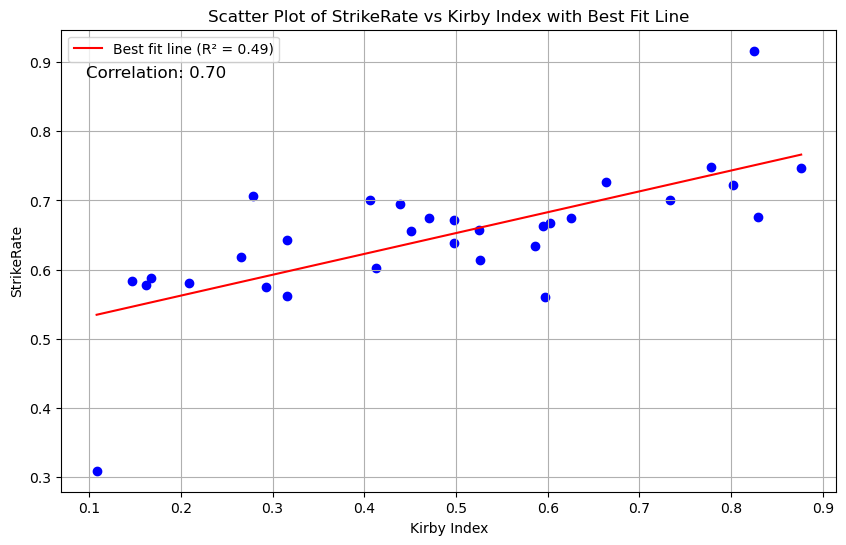

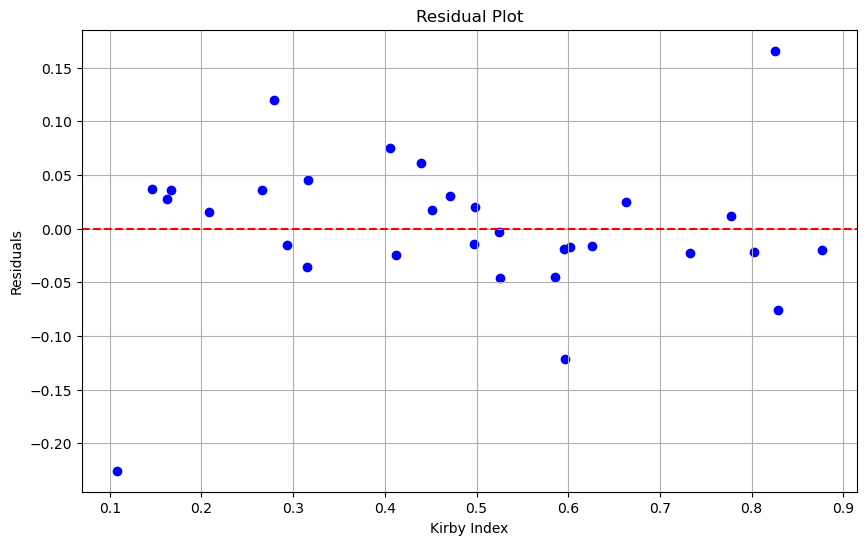

,kirby_index,InZone,Residual
0,0.876452,0.746575,-0.019750
1,0.829355,0.676617,-0.075501
2,0.825161,0.916667,0.165814
5,0.802258,0.721739,-0.022205
7,0.777742,0.748092,0.011543
8,0.732903,0.700297,-0.022725
10,0.663226,0.726872,0.024869
11,0.625484,0.674479,-0.016138
12,0.602258,0.666667,-0.016944
13,0.596774,0.560510,-0.121447


In [12]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Ensure the merged DataFrame has the required columns
if 'StrikeRate' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['StrikeRate']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

     # Calculate residuals
    residuals = y - line

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of StrikeRate vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('StrikeRate')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()
      
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)
else:
    print("Required columns 'StrikeRate' and 'kirby_index' are not present in the DataFrame.")

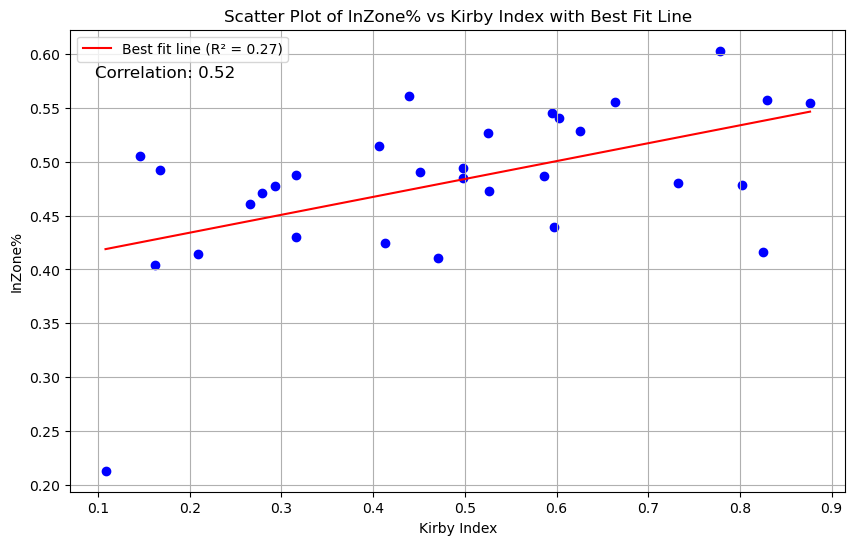

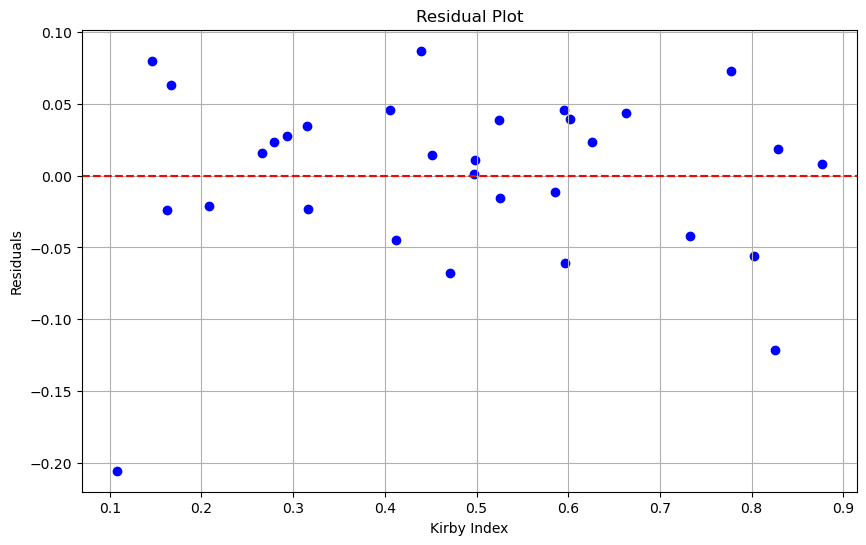

Mean Squared Error (MSE): 0.00


,kirby_index,InZone,Residual
0,0.876452,0.554795,0.008274
1,0.829355,0.557214,0.018515
2,0.825161,0.416667,-0.121336
5,0.802258,0.478261,-0.055938
7,0.777742,0.603053,0.072926
8,0.732903,0.480712,-0.041968
10,0.663226,0.555066,0.043958
11,0.625484,0.528646,0.023805
12,0.602258,0.540230,0.039247
13,0.596774,0.439490,-0.060582


In [13]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Ensure the merged DataFrame has the required columns
if 'InZone' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['InZone']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

    # Calculate residuals
    residuals = y - line

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(residuals ** 2)

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of InZone% vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('InZone%')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display MSE
    print(f'Mean Squared Error (MSE): {mse:.2f}')

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'InZone': y, 'Residual': residuals})
    display(residuals_df)

else:
    print("Required columns 'InZone' and 'kirby_index' are not present in the DataFrame.")


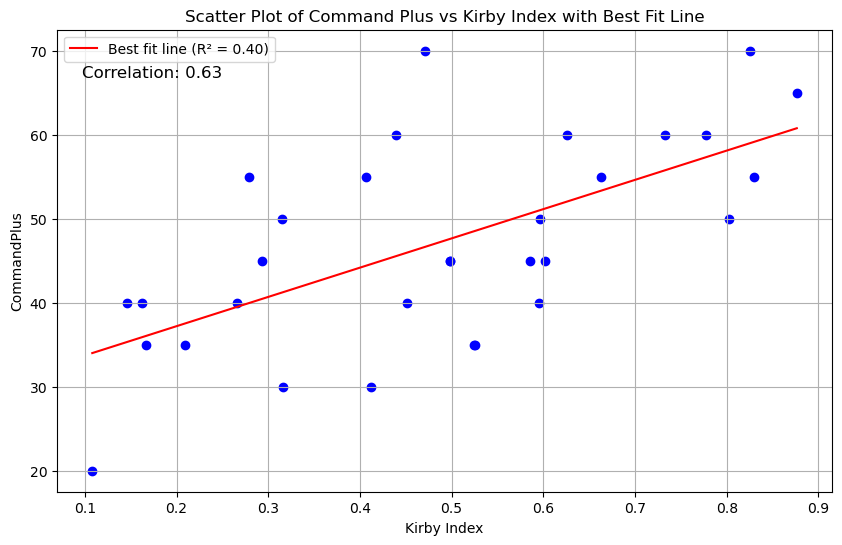

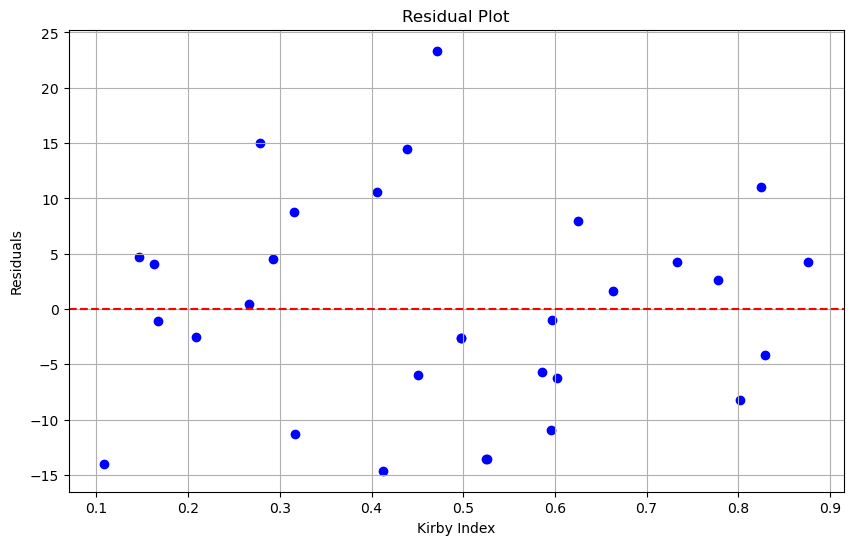

Mean Squared Error (MSE): 86.97


,kirby_index,CommandPlus,Residual
0,0.876452,65,4.227062
1,0.829355,55,-4.132248
2,0.825161,70,11.013841
5,0.802258,50,-8.188289
7,0.777742,60,2.665769
8,0.732903,60,4.227796
10,0.663226,55,1.655118
11,0.625484,60,7.969918
12,0.602258,45,-6.220975
13,0.596774,50,-1.029936


In [14]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Ensure the merged DataFrame has the required columns
if 'CommandPlus' in OAK_select.columns and 'kirby_index' in OAK_select.columns:
    # Extract the relevant columns
    x = OAK_select['kirby_index']
    y = OAK_select['CommandPlus']

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calculate the line of best fit
    line = slope * x + intercept

    # Calculate residuals
    residuals = y - line

    # Calculate Mean Squared Error (MSE)
    mse = np.mean(residuals ** 2)

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c='blue', marker='o')
    plt.plot(x, line, color='red', label=f'Best fit line (R² = {r_value**2:.2f})')

    # Add titles and labels
    plt.title('Scatter Plot of Command Plus vs Kirby Index with Best Fit Line')
    plt.xlabel('Kirby Index')
    plt.ylabel('CommandPlus')
    plt.grid(True)
    plt.legend()

    # Display correlation
    correlation = x.corr(y)
    plt.figtext(0.15, 0.8, f'Correlation: {correlation:.2f}', fontsize=12, color='black')

    # Show the plot
    plt.show()

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Kirby Index')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # Display MSE
    print(f'Mean Squared Error (MSE): {mse:.2f}')

    # Display first few residuals for inspection
    residuals_df = pd.DataFrame({'kirby_index': x, 'CommandPlus': y, 'Residual': residuals})
    display(residuals_df)

else:
    print("Required columns 'InZone' and 'kirby_index' are not present in the DataFrame.")


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:13

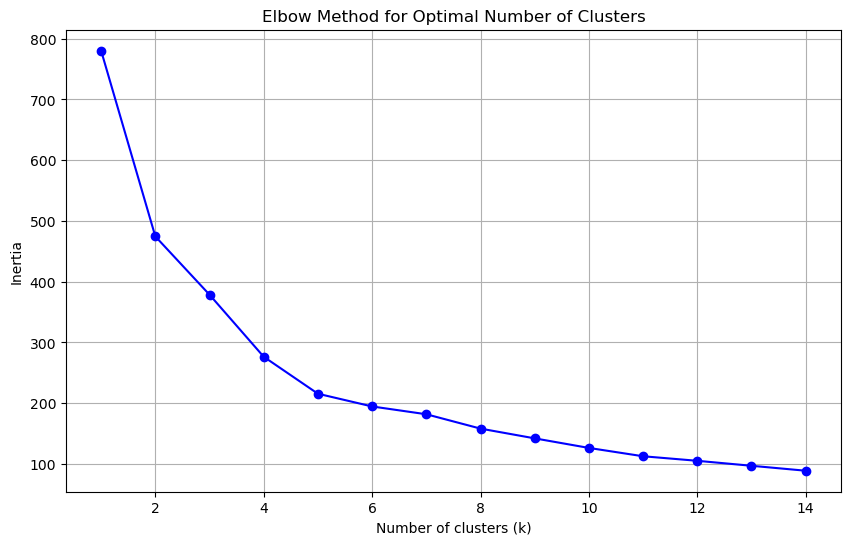

In [15]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Filter for player fastballs
OAK_si_player_HRA_VRA_CL = OAK_si_filtered[OAK_si_filtered['NamePlayer'] == 'James Gonzalez']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
OAK_si_player_HRA_VRA_CL = OAK_si_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = OAK_si_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering for a range of cluster numbers and calculate inertia
inertia = []
K_range = range(1, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow method result
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


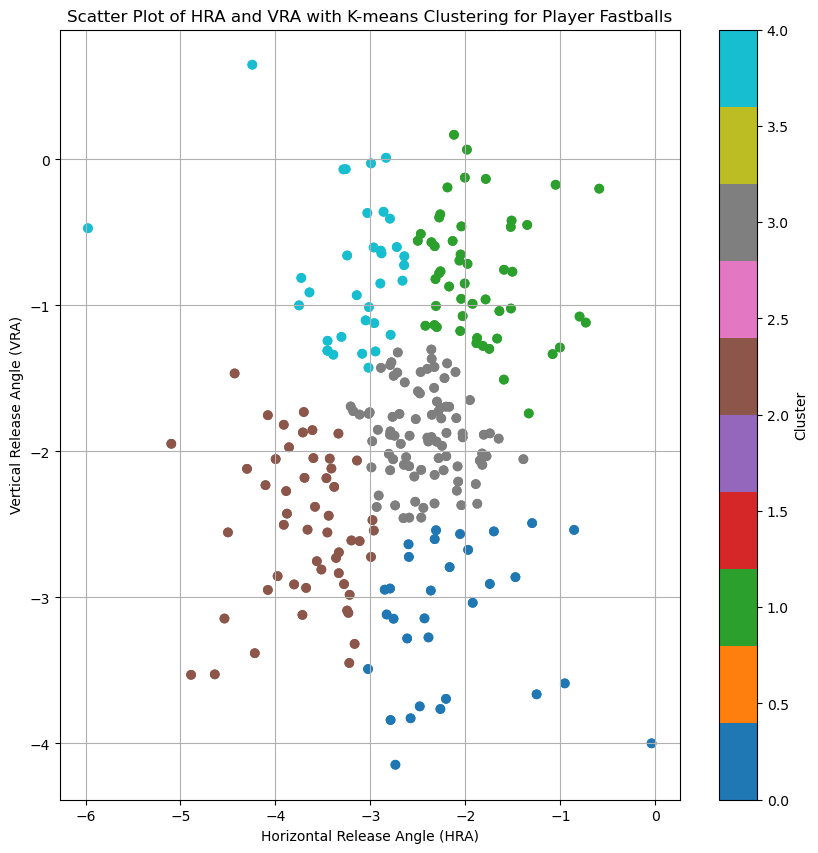

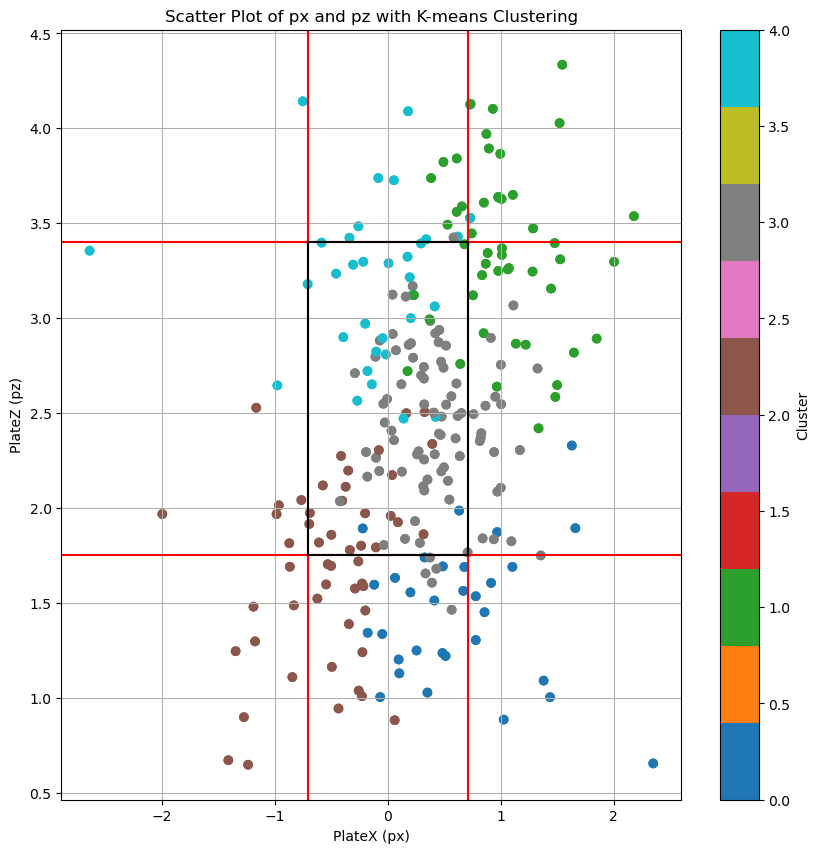

In [16]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=4).fit(X)
OAK_si_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(OAK_si_player_HRA_VRA_CL['HRA'], OAK_si_player_HRA_VRA_CL['VRA'], c=OAK_si_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
plt.title('Scatter Plot of HRA and VRA with K-means Clustering for Player Fastballs')
plt.xlabel('Horizontal Release Angle (HRA)')
plt.ylabel('Vertical Release Angle (VRA)')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.show()


# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(OAK_si_player_HRA_VRA_CL['px'], OAK_si_player_HRA_VRA_CL['pz'], c=OAK_si_player_HRA_VRA_CL['cluster'], cmap='tab10', marker='o')
plt.title('Scatter Plot of px and pz with K-means Clustering')
plt.xlabel('PlateX (px)')
plt.ylabel('PlateZ (pz)')
plt.grid(True)
plt.colorbar(label='Cluster')
plt.axvline(x=0.7083, color='r', linestyle='-')
plt.axvline(x=-0.7083, color='r', linestyle='-')
plt.axhline(y=1.75, color='r', linestyle='-')
plt.axhline(y=3.4, color='r', linestyle='-')

# Add the box
plt.plot([-0.7083, 0.7083], [1.75, 1.75], color='black')
plt.plot([-0.7083, 0.7083], [3.4, 3.4], color='black')
plt.plot([-0.7083, -0.7083], [1.75, 3.4], color='black')
plt.plot([0.7083, 0.7083], [1.75, 3.4], color='black')

plt.show()

In [17]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px
from sklearn.cluster import KMeans
import pandas as pd
import webbrowser


# Filter the DataFrame
OAK_si_player_HRA_VRA_CL = OAK_si_filtered[OAK_si_filtered['NamePlayer'] == 'James Gonzalez']

# Ensure there are no missing values in 'HRA' and 'VRA' columns
OAK_si_player_HRA_VRA_CL = OAK_si_player_HRA_VRA_CL.dropna(subset=['HRA', 'VRA'])

# Prepare the data for clustering
X = OAK_si_player_HRA_VRA_CL[['HRA', 'VRA']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=6, random_state=4).fit(X)
OAK_si_player_HRA_VRA_CL['cluster'] = kmeans.labels_

# Create the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Graph(id='scatter-hra-vra'),
    dcc.Graph(id='scatter-px-pz'),
    dcc.Location(id='url', refresh=True),
    html.Div(id='redirect-url', style={'display': 'none'})
])

# Callback to update the scatter plot for HRA and VRA
@app.callback(
    Output('scatter-hra-vra', 'figure'),
    Input('scatter-hra-vra', 'clickData')
)
def update_hra_vra(clickData):
    fig1 = px.scatter(OAK_si_player_HRA_VRA_CL, x='HRA', y='VRA', color='cluster',
                      title='Catcher View Scatter Plot of HRA and VRA with K-means Clustering for Player Fastballs',
                      labels={'HRA': 'Horizontal Release Angle (HRA)', 'VRA': 'Vertical Release Angle (VRA)'},
                      hover_data=['URL'])
    fig1.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig1.update_traces(marker=dict(size=10))
    
    return fig1

# Callback to update the scatter plot for px and pz
@app.callback(
    Output('scatter-px-pz', 'figure'),
    Input('scatter-px-pz', 'clickData')
)
def update_px_pz(clickData):
    fig2 = px.scatter(OAK_si_player_HRA_VRA_CL, x='px', y='pz', color='cluster',
                      title='Catcher View Scatter Plot of px and pz with K-means Clustering',
                      labels={'px': 'PlateX (px)', 'pz': 'PlateZ (pz)'},
                      hover_data=['URL'])
    fig2.update_layout(coloraxis_colorbar=dict(title='Cluster'))
    fig2.update_traces(marker=dict(size=10))
    
    fig2.add_shape(type='line', x0=0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=-0.7083, y0=1.75, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=1.75, y1=1.75, line=dict(color='Red'))
    fig2.add_shape(type='line', x0=-0.7083, x1=0.7083, y0=3.4, y1=3.4, line=dict(color='Red'))
    fig2.add_shape(type='rect', x0=-0.7083, x1=0.7083, y0=1.75, y1=3.4, line=dict(color='Black'))
    
    return fig2

# Callback to handle URL redirection
@app.callback(
    Output('redirect-url', 'children'),
    [Input('scatter-hra-vra', 'clickData'),
     Input('scatter-px-pz', 'clickData')]
)
def redirect_url(clickDataHraVra, clickDataPxPz):
    if clickDataHraVra is not None:
        point_index = clickDataHraVra['points'][0]['pointIndex']
        url = OAK_si_player_HRA_VRA_CL.iloc[point_index]['URL']
        return dcc.Location(href=url, id='url')
    elif clickDataPxPz is not None:
        point_index = clickDataPxPz['points'][0]['pointIndex']
        url = OAK_si_player_HRA_VRA_CL.iloc[point_index]['URL']
        return dcc.Location(href=url, id='url')
    return ""

# Open a web browser tab with the app URL
def open_browser():
    webbrowser.open_new_tab("http://127.0.0.1:8052/")

# Run the app
if __name__ == '__main__':
    open_browser()
    app.run_server(debug=True, port=8052)


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [18]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Set the environment variable to avoid the memory leak warning
os.environ['OMP_NUM_THREADS'] = '2'

# Define the maximum number of clusters
max_clusters = 10

# Function to find the optimal number of clusters with silhouette score calculation
def find_optimal_clusters_with_silhouette(data, max_clusters):
    inertia = []
    silhouette_scores = []
    K_range = range(3, max_clusters + 1)  # Silhouette score is undefined for k=1
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(data)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
    
    return inertia, silhouette_scores

# Store the results
results = []

# Iterate over each player
players = OAK_si_filtered['NamePlayer'].unique()
for player in players:
    # Filter for player's fastballs
    player_data = OAK_si_filtered[OAK_si_filtered['NamePlayer'] == player]
    
    # Ensure there are no missing values in 'HRA' and 'VRA' columns
    player_data = player_data.dropna(subset=['HRA', 'VRA'])
    
    # Prepare the data for clustering
    X = player_data[['HRA', 'VRA']]
    
    if not X.empty:
        # Find the optimal number of clusters and calculate silhouette scores
        inertia, silhouette_scores = find_optimal_clusters_with_silhouette(X, max_clusters)
        
        # Find the optimal number of clusters with the highest silhouette score
        optimal_clusters = range(3, max_clusters + 1)[np.argmax(silhouette_scores)]
        
        # Append the result
        results.append({'NamePlayer': player, 'Optimal Clusters': optimal_clusters, 'Inertia': inertia[np.argmax(silhouette_scores)], 'Silhouette Score': max(silhouette_scores)})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print the results for debugging


c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[17], line 55, in update_px_pz(clickData=None)
     50 @app.callback(
     51     Output('scatter-px-pz', 'figure'),
     52     Input('scatter-px-pz', 'clickData')
     53 )
     54 def update_px_pz(clickData):
---> 55     fig2 = px.scatter(OAK_si_player_HRA_VRA_CL, x='px', y='pz', color='cluster',
        OAK_si_player_HRA_VRA_CL =       PitcherId      NamePlayer PitHand        x0         y0        z0  \
4103     686857  James Gonzalez       L  2.059455  55.000000  6.148930   
4104     686857  James Gonzalez       L  2.059455  55.000000  6.148930   
4105     686857  James Gonzalez       L  1.553236  55.000000  6.272388   
4187     686857  James Gonzalez       L  1.553236  55.000000  6.272388   
4188     686857  James Gonzalez       L  1.689070  55.000000  6.270823   
4189     686857  James Gonzalez       L  1.689070  55.000000 

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\jreydel\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a m

In [19]:
print(results_df)

           NamePlayer  Optimal Clusters     Inertia  Silhouette Score
0       Jacob Watters                 4  192.170443          0.348669
1           J.T. Ginn                10   97.873264          0.356802
2       Michel Otañez                 3  221.933024          0.377068
3      Brandon Bielak                 3   75.251430          0.379795
4       Austin Briggs                 8  118.342590          0.353198
5      Tyler Ferguson                 5   74.455197          0.375144
6        Aaron Brooks                 4  163.577524          0.354998
7        Osvaldo Bido                 8   59.984951          0.355497
8      Royber Salinas                 9   39.835791          0.456054
9     Scott Alexander                 5   54.128859          0.378745
10     T.J. McFarland                 8   40.770166          0.351964
11          Alex Wood                 4  152.157439          0.349762
12     Ross Stripling                10   35.146220          0.426186
13           JP Sear

In [22]:
results_df.rename(columns={'Player': 'NamePlayer'}, inplace=True)

# Merge results_df onto OAK_select
OAK_full_sinker_w_optimal_clusters = pd.merge(OAK_full_sinker_command_unique, results_df, how='left', on='NamePlayer')

columns_to_drop = ['VRA', 'HRA', 'ReleaseX', 'ReleaseZ', 'PlayerID', 'Inertia']
OAK_full_sinker_w_optimal_clusters = OAK_full_sinker_w_optimal_clusters.drop(columns=columns_to_drop)

display(OAK_full_sinker_w_optimal_clusters)


,NamePlayer,PitcherId,VRA_percentile,HRA_percentile,release_pos_z_percentile,release_pos_x_percentile,kirby_index,StrikeRate,CalledStrikeRate,CommandPlus,InZone,Optimal Clusters,Silhouette Score
0,Ross Stripling,548389,0.806452,0.967742,0.935484,0.838710,0.876452,0.746575,0.226027,65,0.554795,10,0.426186
1,JP Sears,676664,0.935484,0.870968,0.387097,0.967742,0.829355,0.676617,0.233831,55,0.557214,10,0.374225
2,Scott Alexander,518397,0.870968,0.838710,0.838710,0.645161,0.825161,0.916667,0.250000,70,0.416667,5,0.378745
3,Brandon Bielak,656232,0.709677,0.935484,0.709677,0.935484,0.802258,0.721739,0.147826,50,0.478261,3,0.379795
4,T.J. McFarland,519008,0.967742,0.354839,0.903226,0.870968,0.777742,0.748092,0.225191,60,0.603053,8,0.351964
5,Aaron Brooks,605156,0.741935,0.806452,0.612903,0.709677,0.732903,0.700297,0.157270,60,0.480712,4,0.354998
6,Luis Carrasco,682918,0.903226,0.645161,0.193548,0.548387,0.663226,0.726872,0.140969,55,0.555066,10,0.381068
7,Jake Garland,687195,0.548387,0.774194,0.483871,0.741935,0.625484,0.674479,0.197917,60,0.528646,8,0.353625
8,Alex Wood,622072,0.645161,0.677419,0.129032,0.903226,0.602258,0.666667,0.192529,45,0.540230,4,0.349762
9,Mitch Spence,687765,0.258065,0.903226,0.774194,0.806452,0.596774,0.560510,0.082803,50,0.439490,4,0.386625
